# EDA

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('data/HI-Small_Trans.csv')

def rename_columns(df):
    new_cols = {}
    for col in df.columns:
        new_col = col.lower().replace(' ', '_')
        new_cols[col] = new_col
    return df.rename(columns=new_cols)


df = rename_columns(df)
# Rename the 'account' column to 'from_account'
df = df.rename(columns={'account': 'from_account'})

# Rename the 'account.1' column to 'to_account'
df = df.rename(columns={'account.1': 'to_account'})

In [6]:
df.head()

,timestamp,from_bank,from_account,to_bank,to_account,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [28]:
# save the dataframe to a new csv file overwriting the old one
df.to_csv('data/HI-Small_Trans_adjusted.csv', index=False)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   timestamp           object 
 1   from_bank           int64  
 2   from_account        object 
 3   to_bank             int64  
 4   to_account          object 
 5   amount_received     float64
 6   receiving_currency  object 
 7   amount_paid         float64
 8   payment_currency    object 
 9   payment_format      object 
 10  is_laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


In [12]:
df.describe()

,From Bank,To Bank,Amount Received,Amount Paid,Is Laundering
count,5.078345e+06,5.078345e+06,5.078345e+06,5.078345e+06,5.078345e+06
mean,4.573057e+04,6.574456e+04,5.988726e+06,4.509273e+06,1.019427e-03
std,8.176562e+04,8.409299e+04,1.037183e+09,8.697728e+08,3.191219e-02
min,1.000000e+00,1.000000e+00,1.000000e-06,1.000000e-06,0.000000e+00
25%,1.190000e+02,4.259000e+03,1.833700e+02,1.844800e+02,0.000000e+00
50%,9.679000e+03,2.156800e+04,1.411010e+03,1.414540e+03,0.000000e+00
75%,2.862800e+04,1.223320e+05,1.234627e+04,1.229784e+04,0.000000e+00
max,3.563030e+05,3.562940e+05,1.046302e+12,1.046302e+12,1.000000e+00


In [13]:
'''Checking for any null values'''

print('Null Values =',df.isnull().values.any())

Null Values = False


## Payment_format deep dive

In [24]:
# Get the count and percentage of each payment format
counts = df['payment_format'].value_counts().to_frame()
counts['percentage_of_transaction'] = counts['payment_format'] / len(df) * 100
print(counts)


              payment_format  percentage_of_transaction
Cheque               1864331                  36.711389
Credit Card          1323324                  26.058174
ACH                   600797                  11.830567
Cash                  490891                   9.666358
Reinvestment          481056                   9.472692
Wire                  171855                   3.384075
Bitcoin               146091                   2.876744


In [23]:
# Calculate the average amount paid per transaction for each payment format, and sort the results in descending order

# Group the DataFrame by payment_format and calculate the mean payment amount for each group
avg_amount = df.groupby('payment_format')['amount_paid'].mean()

# Divide the mean payment amount by the number of transactions for each payment_format to get the average amount_paid per transaction
num_transactions = df['payment_format'].value_counts()
avg_amount_per_transaction = avg_amount / num_transactions

# Convert the resulting Series into a DataFrame and sort it by the average amount_paid per transaction in descending order
result_df = avg_amount_per_transaction.to_frame()

# Print the resulting DataFrame
print(result_df)


                      0
ACH           15.808978
Bitcoin        0.000211
Cash          14.993011
Cheque         3.273883
Credit Card    0.065580
Reinvestment   5.394401
Wire          28.375081


## Bank Deep Dive

In [27]:
# Get the count and percentage of transactions grouped by from_bank
from_counts = df.groupby('from_bank').size().sort_values(ascending=False).head(10)
from_pct = from_counts / len(df) * 100

# Get the count and percentage of transactions grouped by to_bank
to_counts = df.groupby('to_bank').size().sort_values(ascending=False).head(10)
to_pct = to_counts / len(df) * 100

# Combine the count and percentage results into a single DataFrame
result_df = pd.concat([from_counts, from_pct, to_counts, to_pct], axis=1, keys=['from_count', 'from_pct', 'to_count', 'to_pct'])

# Print the resulting DataFrame
print(result_df)

     from_count  from_pct  to_count    to_pct
70     449859.0  8.858378       NaN       NaN
10      81629.0  1.607394   42547.0  0.837812
12      79754.0  1.570472   41872.0  0.824521
1       62211.0  1.225025   30115.0  0.593008
15      52511.0  1.034018   38721.0  0.762473
220     52417.0  1.032167   30625.0  0.603051
20      41008.0  0.807507   22048.0  0.434157
3       38413.0  0.756408   25627.0  0.504633
7       31086.0  0.612129   23029.0  0.453475
211     30451.0  0.599624   20576.0  0.405171
28          NaN       NaN   21160.0  0.416671


## Bank Account Analyis

In [10]:
# Get the count of distinct 'from_account' and 'to_account' values
from_count = df['from_account'].nunique()
to_count = df['to_account'].nunique()

print("Distinct 'from_account' count:", from_count)
print("Distinct 'to_account' count:", to_count)


Distinct 'from_account' count: 496995
Distinct 'to_account' count: 420636


In [14]:
# Get the count and percentage of accounts that overlap between 'from_account' and 'to_account'
from_set = set(df['from_account'].unique())
to_set = set(df['to_account'].unique())
overlap_count = len(from_set.intersection(to_set))

total_count = len(from_set.union(to_set))

overlap_pct = overlap_count / total_count * 100

print("Number of accounts in both 'from_account' and 'to_account':", overlap_count)
print("Percentage of accounts in both 'from_account' and 'to_account': {:.2f}%".format(overlap_pct))


Number of accounts in both 'from_account' and 'to_account': 402551
Percentage of accounts in both 'from_account' and 'to_account': 78.15%


In [13]:
# Get the count and percentage of accounts that don't overlap between 'from_account' and 'to_account'
from_set = set(df['from_account'].unique())
to_set = set(df['to_account'].unique())
non_overlap_count = len(from_set.symmetric_difference(to_set))

total_count = len(from_set.union(to_set))

non_overlap_pct = non_overlap_count / total_count * 100

print("Number of accounts not in both 'from_account' and 'to_account':", non_overlap_count)
print("Percentage of accounts not in both 'from_account' and 'to_account': {:.2f}%".format(non_overlap_pct))


Number of accounts not in both 'from_account' and 'to_account': 112529
Percentage of accounts not in both 'from_account' and 'to_account': 21.85%


## Group By classes

Payment Format
ACH             [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
Bitcoin         [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
Cash            [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
Cheque          [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
Credit Card     [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
Reinvestment    [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
Wire            [[AxesSubplot(0.125,0.666111;0.336957x0.213889...
dtype: object

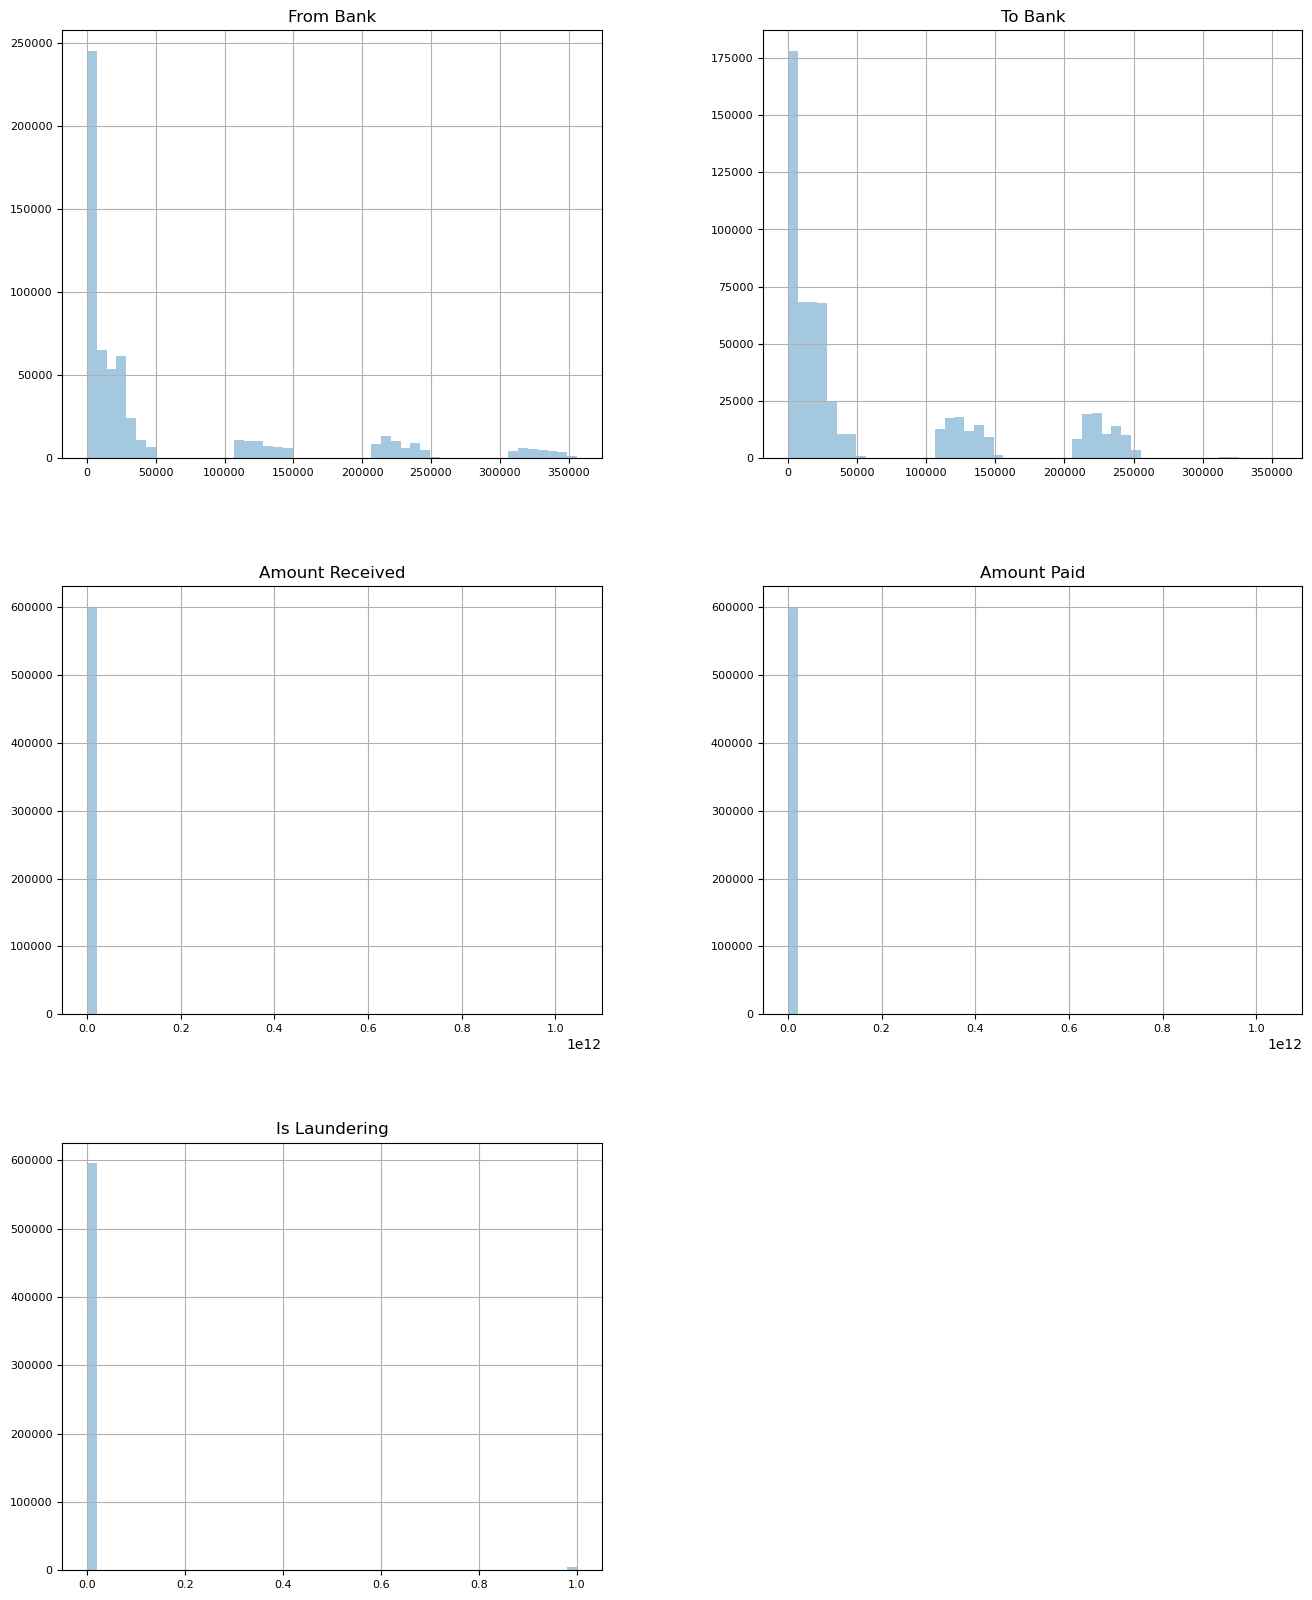

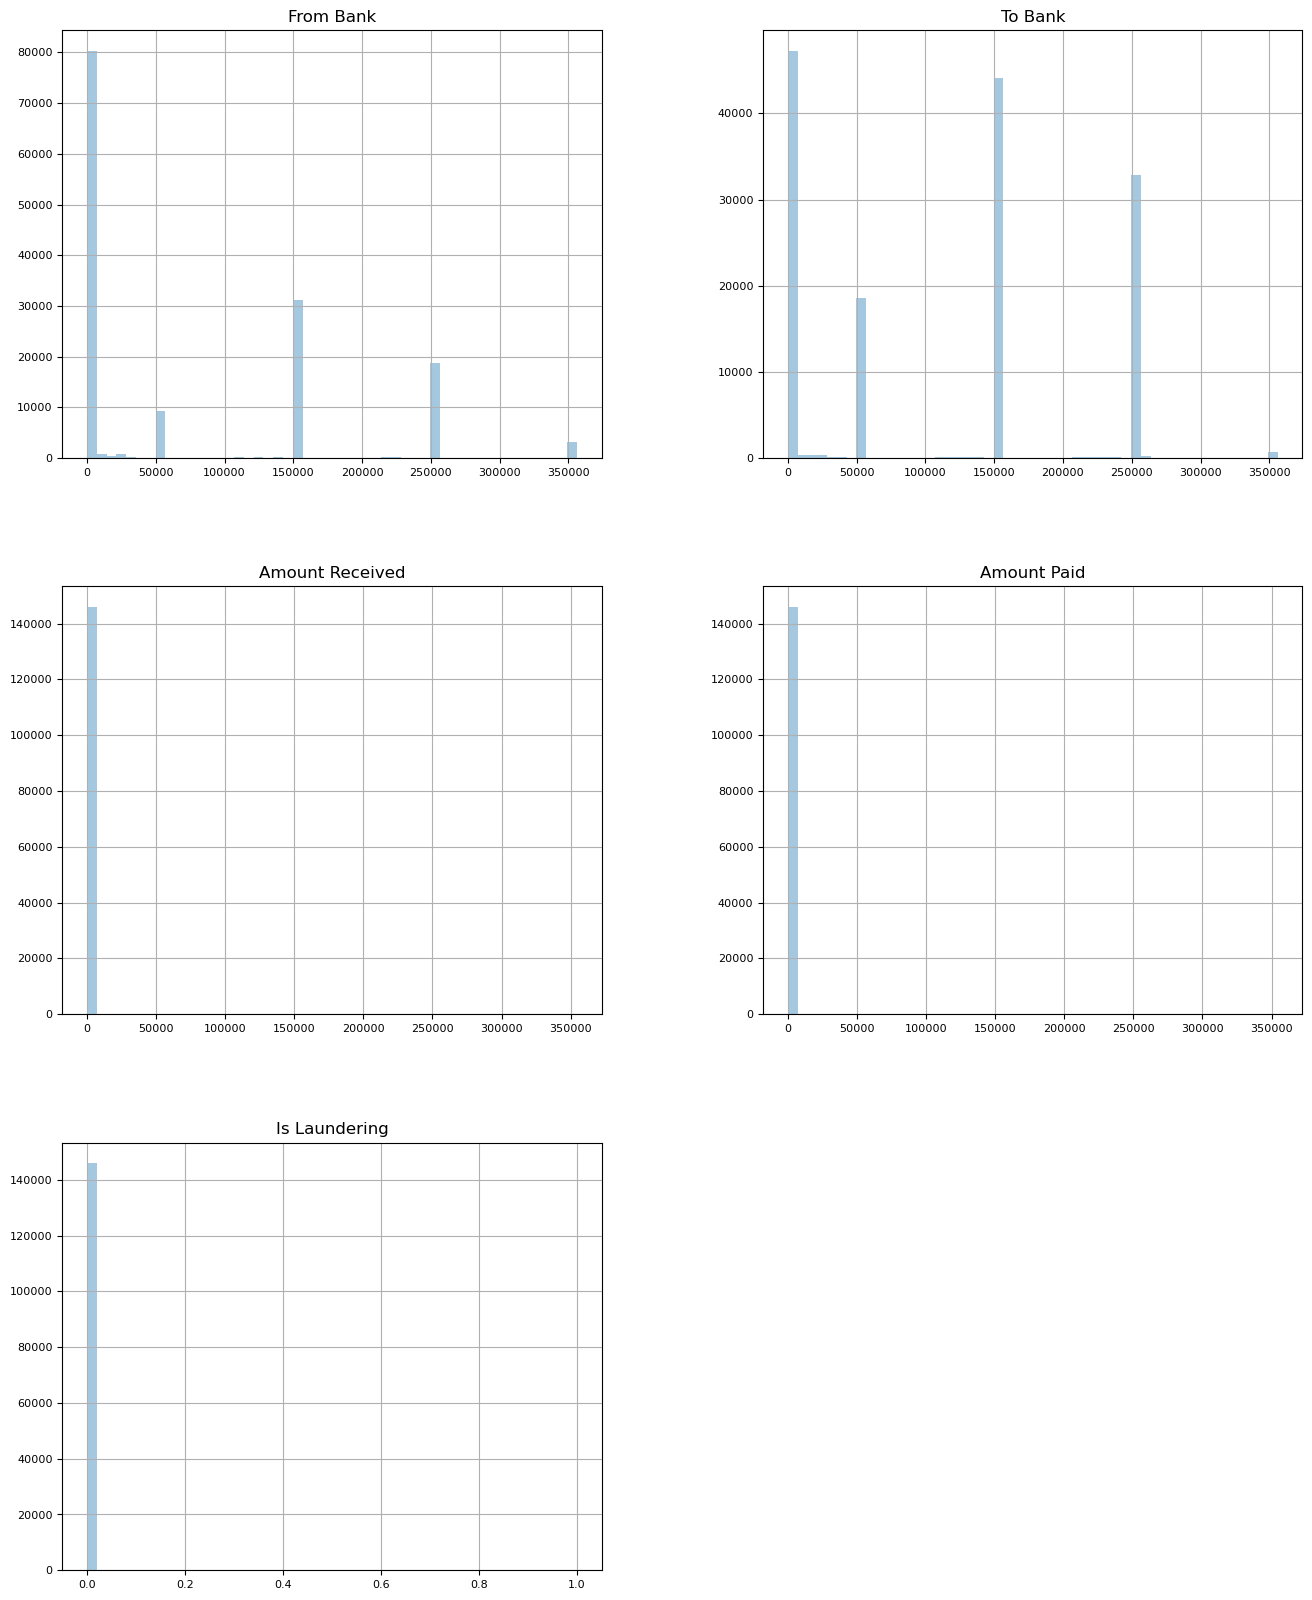

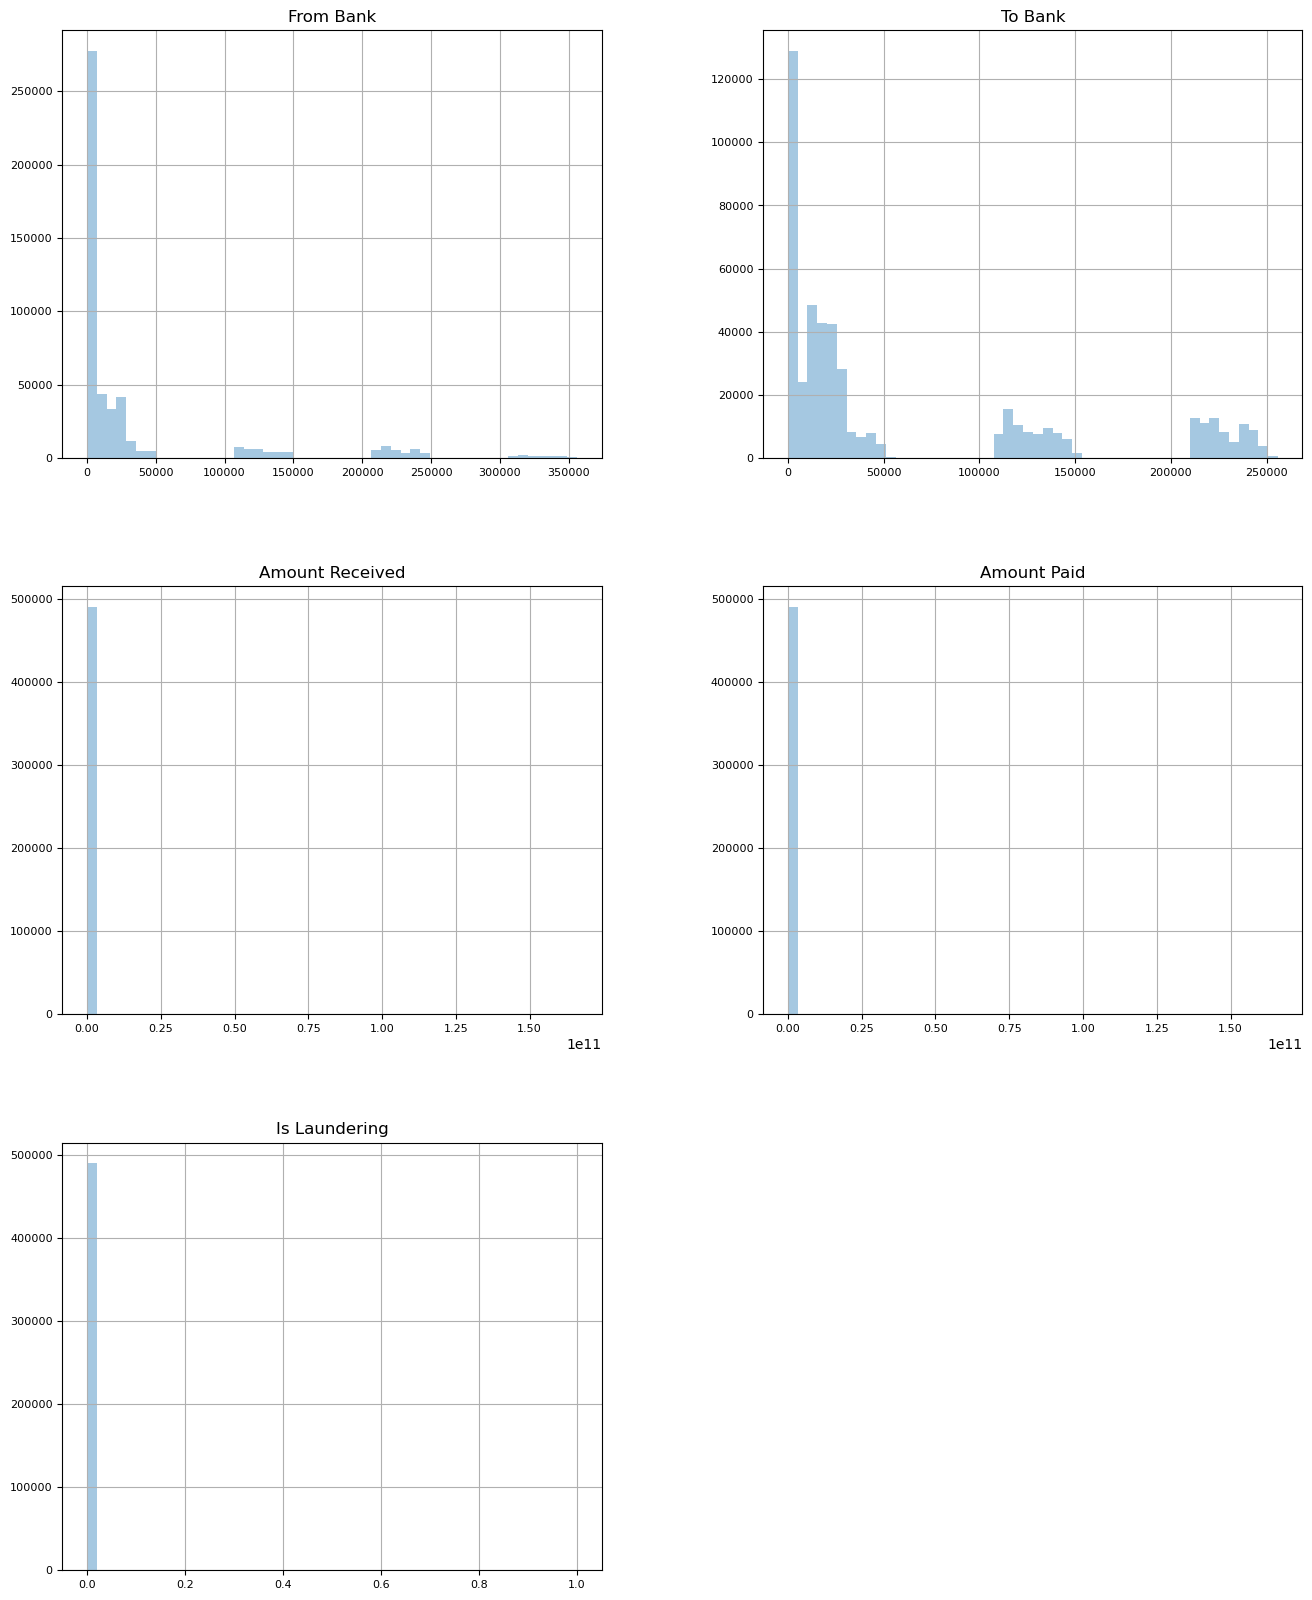

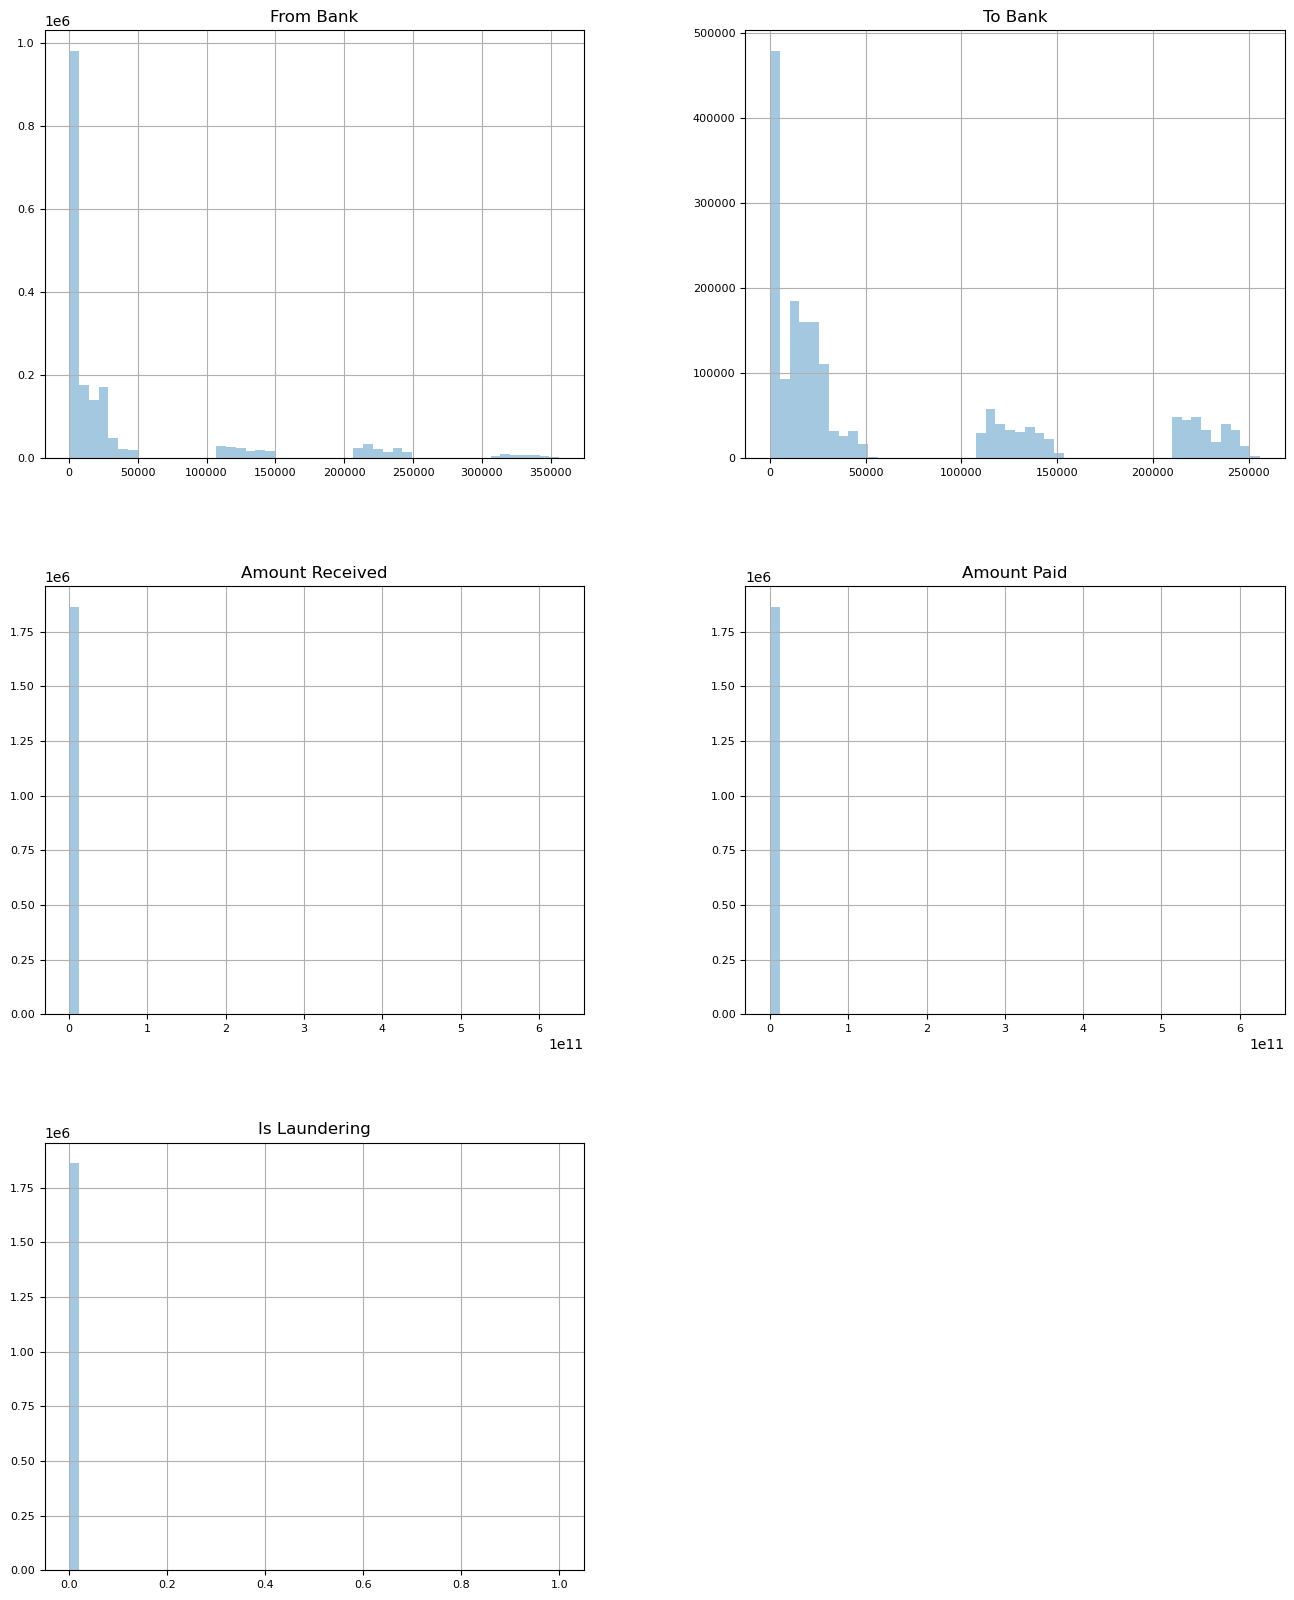

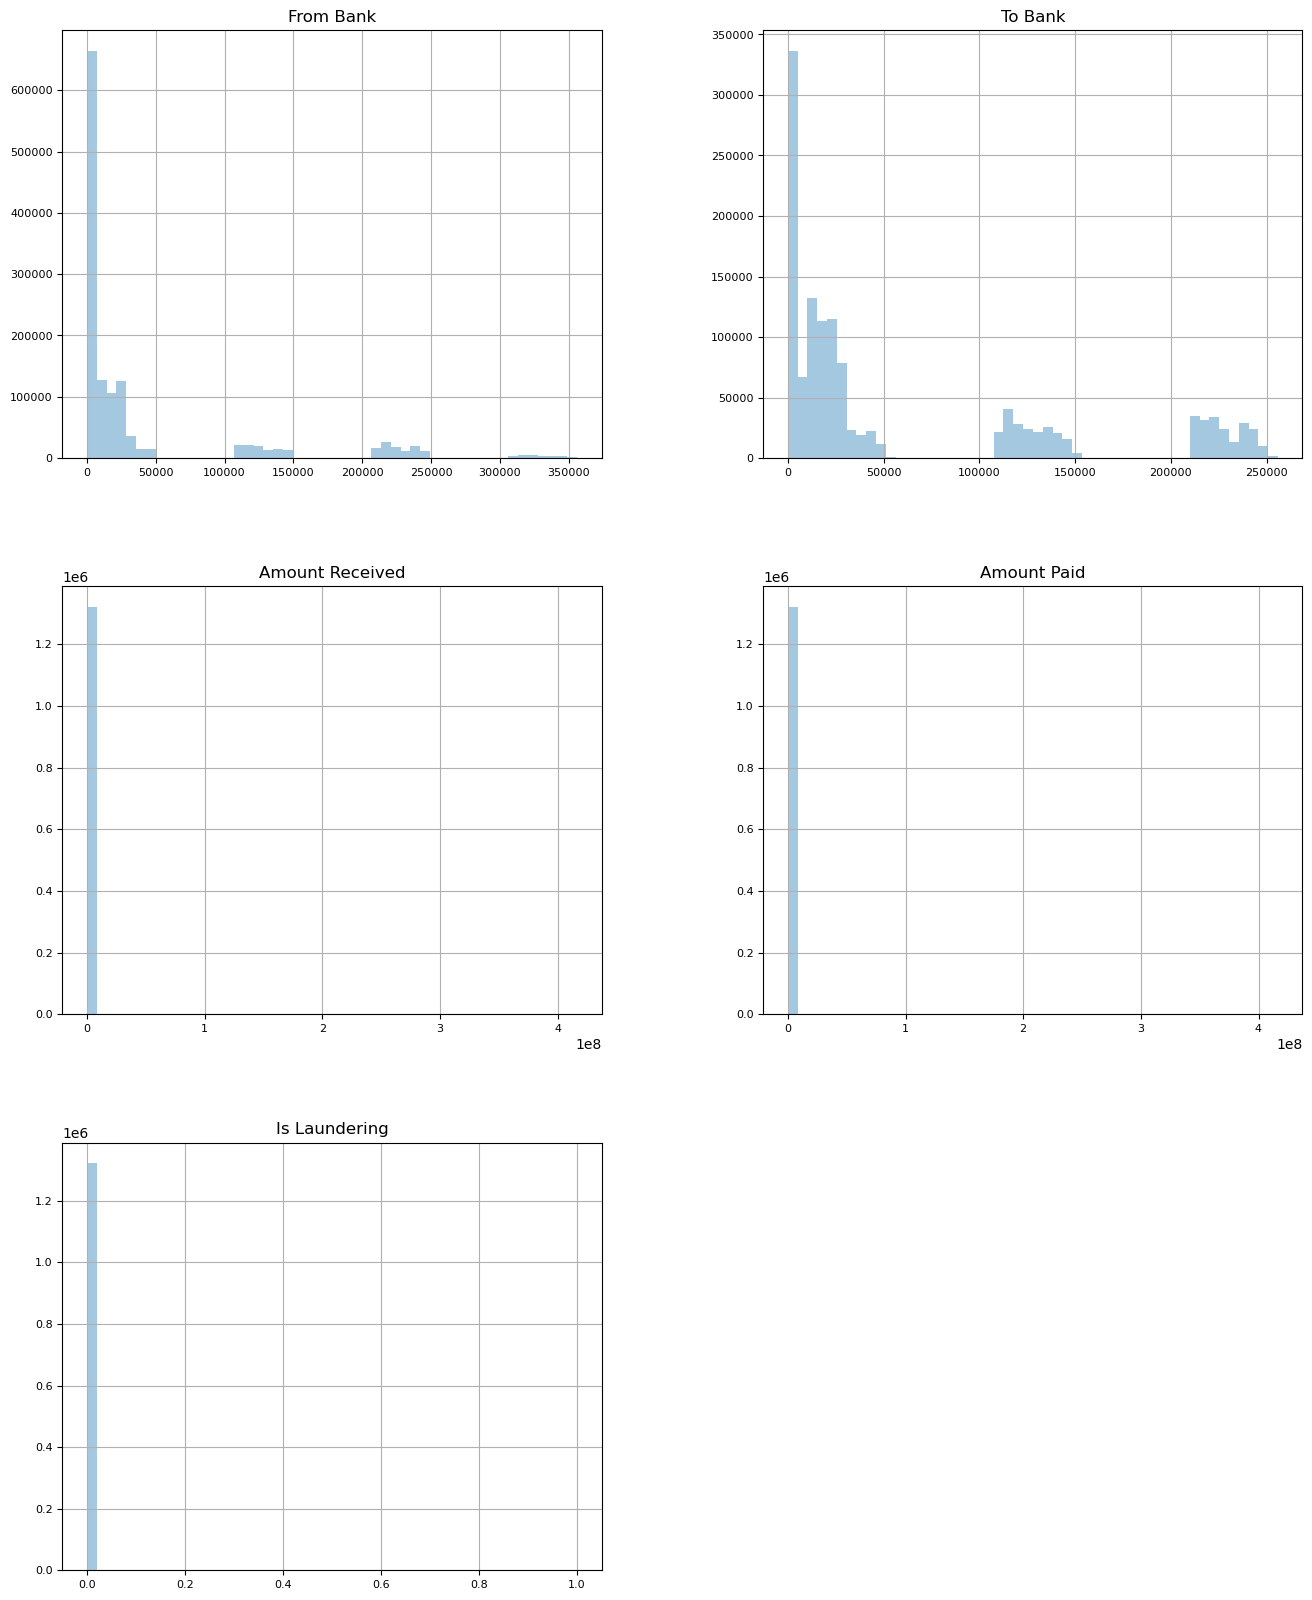

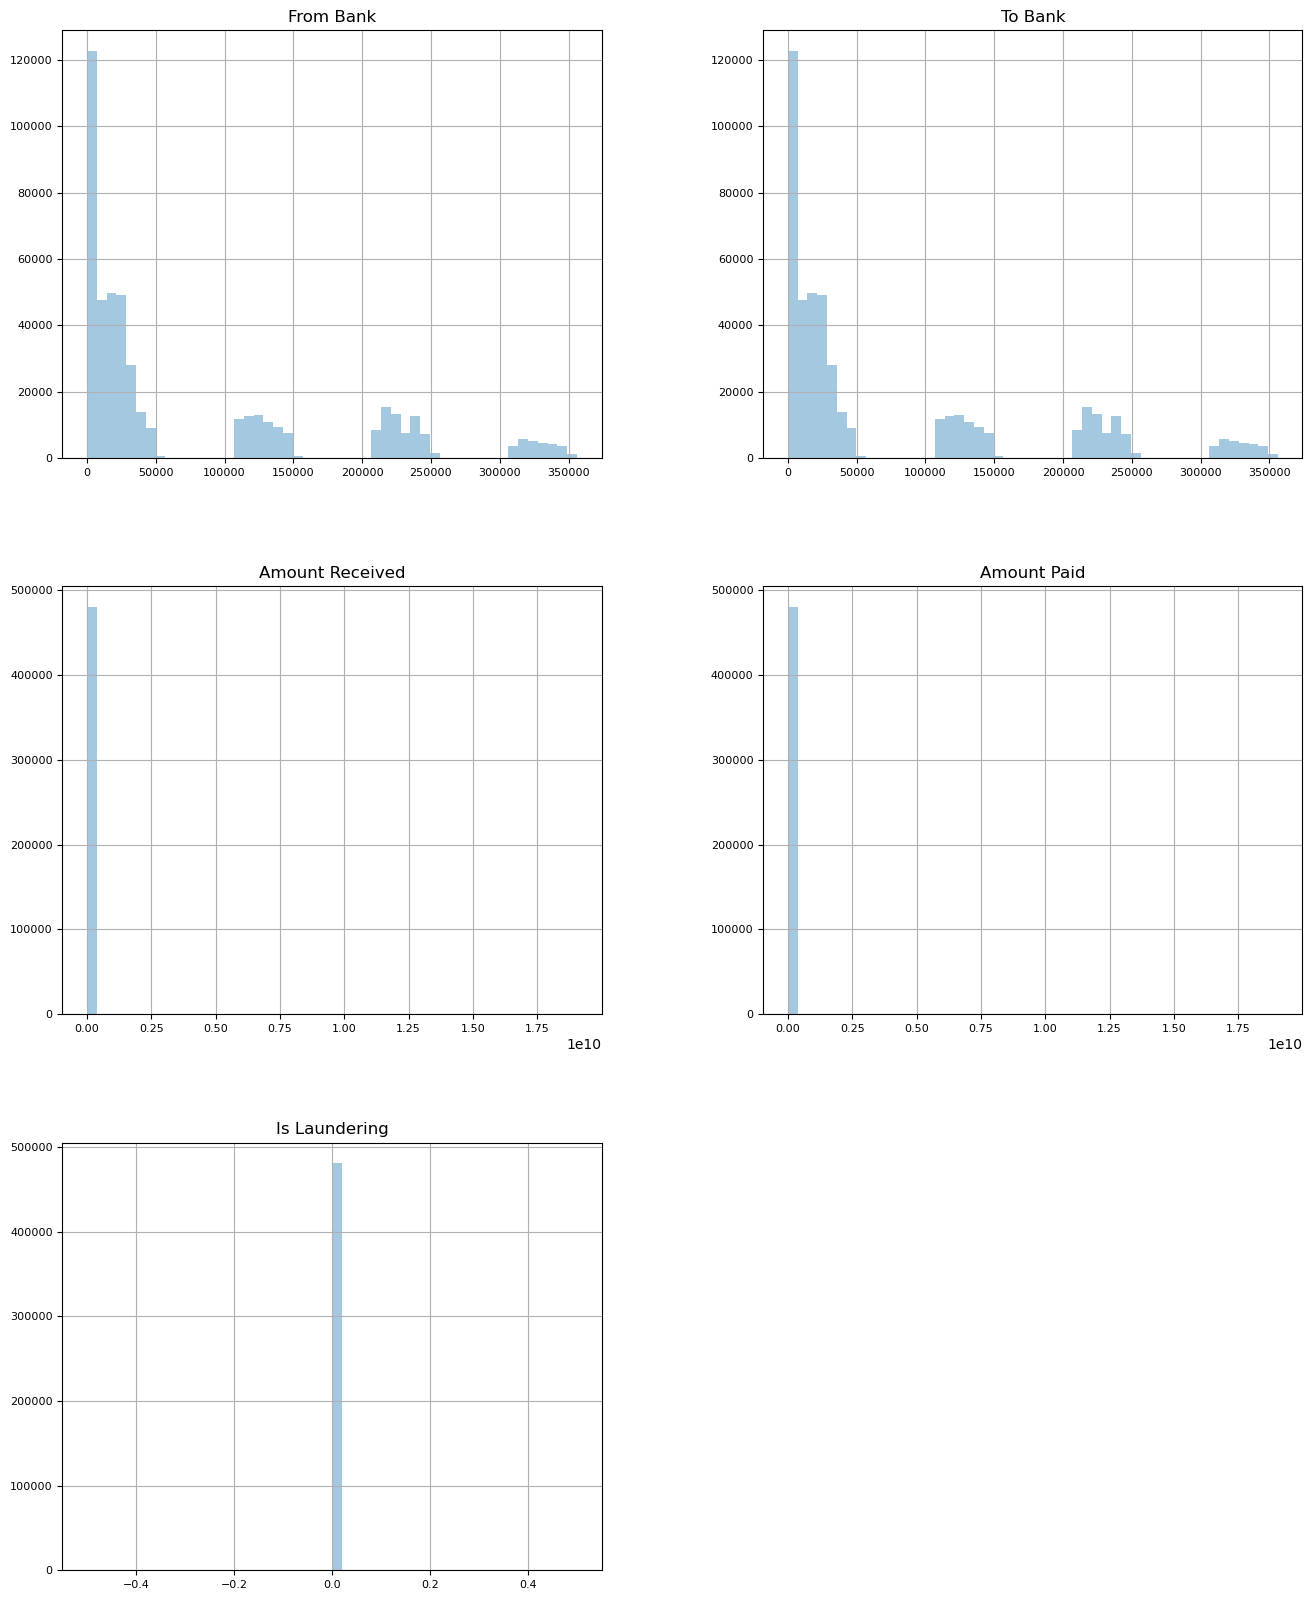

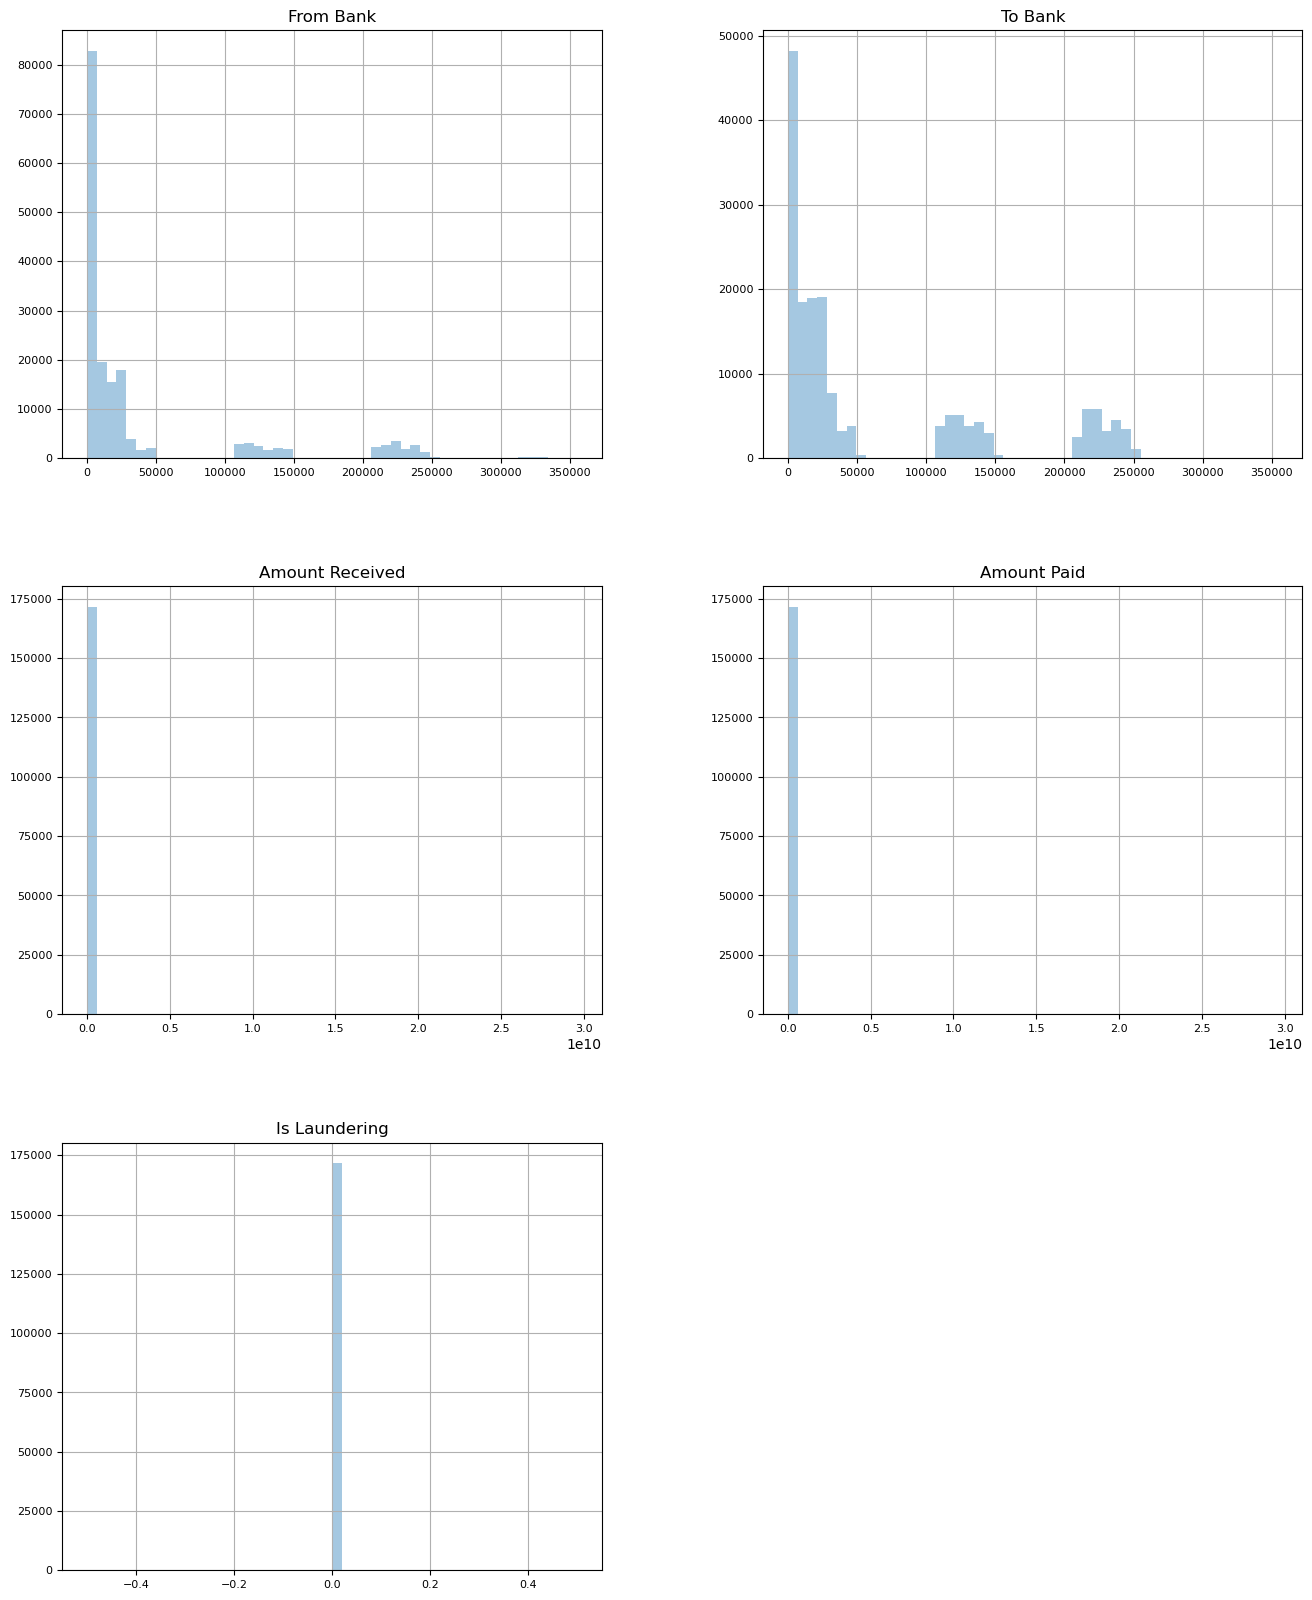

In [18]:
''' Visualising the variables by grouping them by class '''

df.groupby('Payment Format').hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8,alpha=0.4)

## Check multicolinearity between variables 

Check if we need to remove features based on the high colinearity.

<AxesSubplot:title={'center':'Correlation Matrix'}>

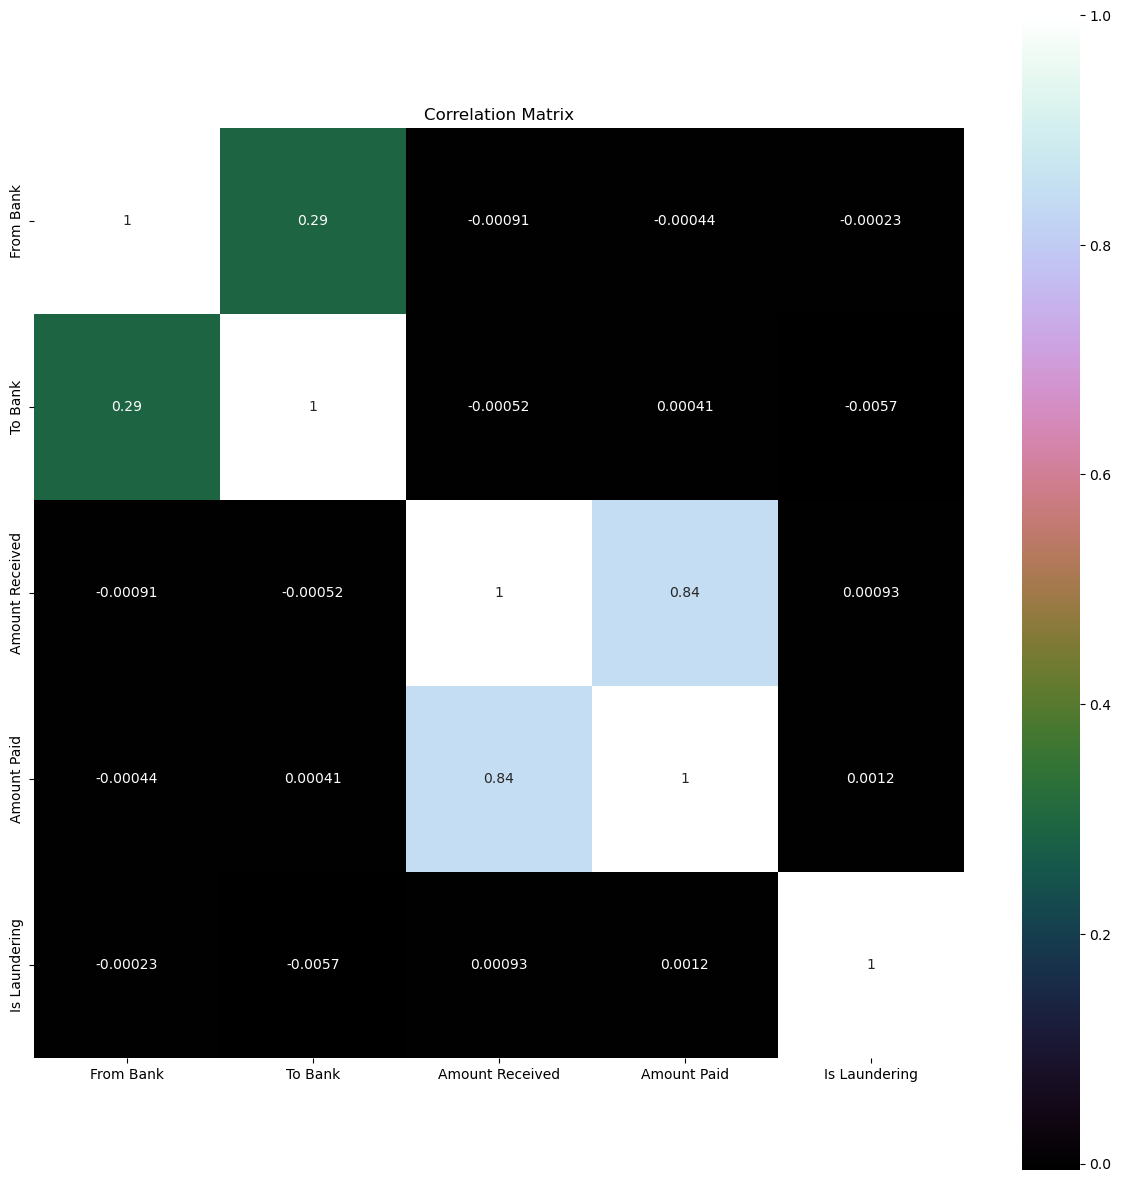

In [17]:

''' correlation matrix to check multicolinearity between variables '''

correlation = df.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')